# K-Nearest Neighbors (k-NN) Classifier on the California Housing Dataset

In this notebook we will:

1. **Load and Explore the Data:** We assume that the dataset (e.g. `housing.csv`) contains several numerical features including the house price and a categorical column `ocean_proximity` (which we will use as our target variable).
2. **Split the Data:** Create training and testing sets. Since `ocean_proximity` is categorical (and its classes may be imbalanced), we will use stratification.
3. **Build a Preprocessing Pipeline:** Use scikit-learn’s pipeline along with imputation and scaling. We also define a custom transformer (a column selector) for later flexibility.
4. **Build a Full Modeling Pipeline:** Combine preprocessing with the k‑nn classifier using the Minkowski distance metric (with parameter \( $p$ \)) and treat \( $p$ \) as a hyperparameter.
5. **Compare Different \( $p$ \) Values:** We will experiment with \( $p$ = 1,2,10 \) and even \( p = -10 \) (which should yield poor performance or error).
6. **Hyperparameter Tuning with GridSearchCV:** Search for the optimal \( $p$ \) using cross-validation.
7. **Feature Importance Analysis:** Evaluate which features are most important by removing one at a time and assessing the drop in accuracy.

**Note:** Adjust the file path for the dataset as needed. 

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scikit-learn modules for model building and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin

# For nice plots in notebooks (optional)
%matplotlib inline

# to make this notebook's output stable across runs
np.random.seed(42)


## 1. Load and Explore the Data

We load the dataset which we assume to have a column `ocean_proximity` (categorical) along with several numerical features.



In [2]:
# Load the dataset and display the first few rows
housing = pd.read_csv("housing.csv")
print("Dataset shape:", housing.shape)
print("Columns in the dataset:", housing.columns.tolist())

# Display the first few rows
housing.head()

Dataset shape: (20640, 10)
Columns in the dataset: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


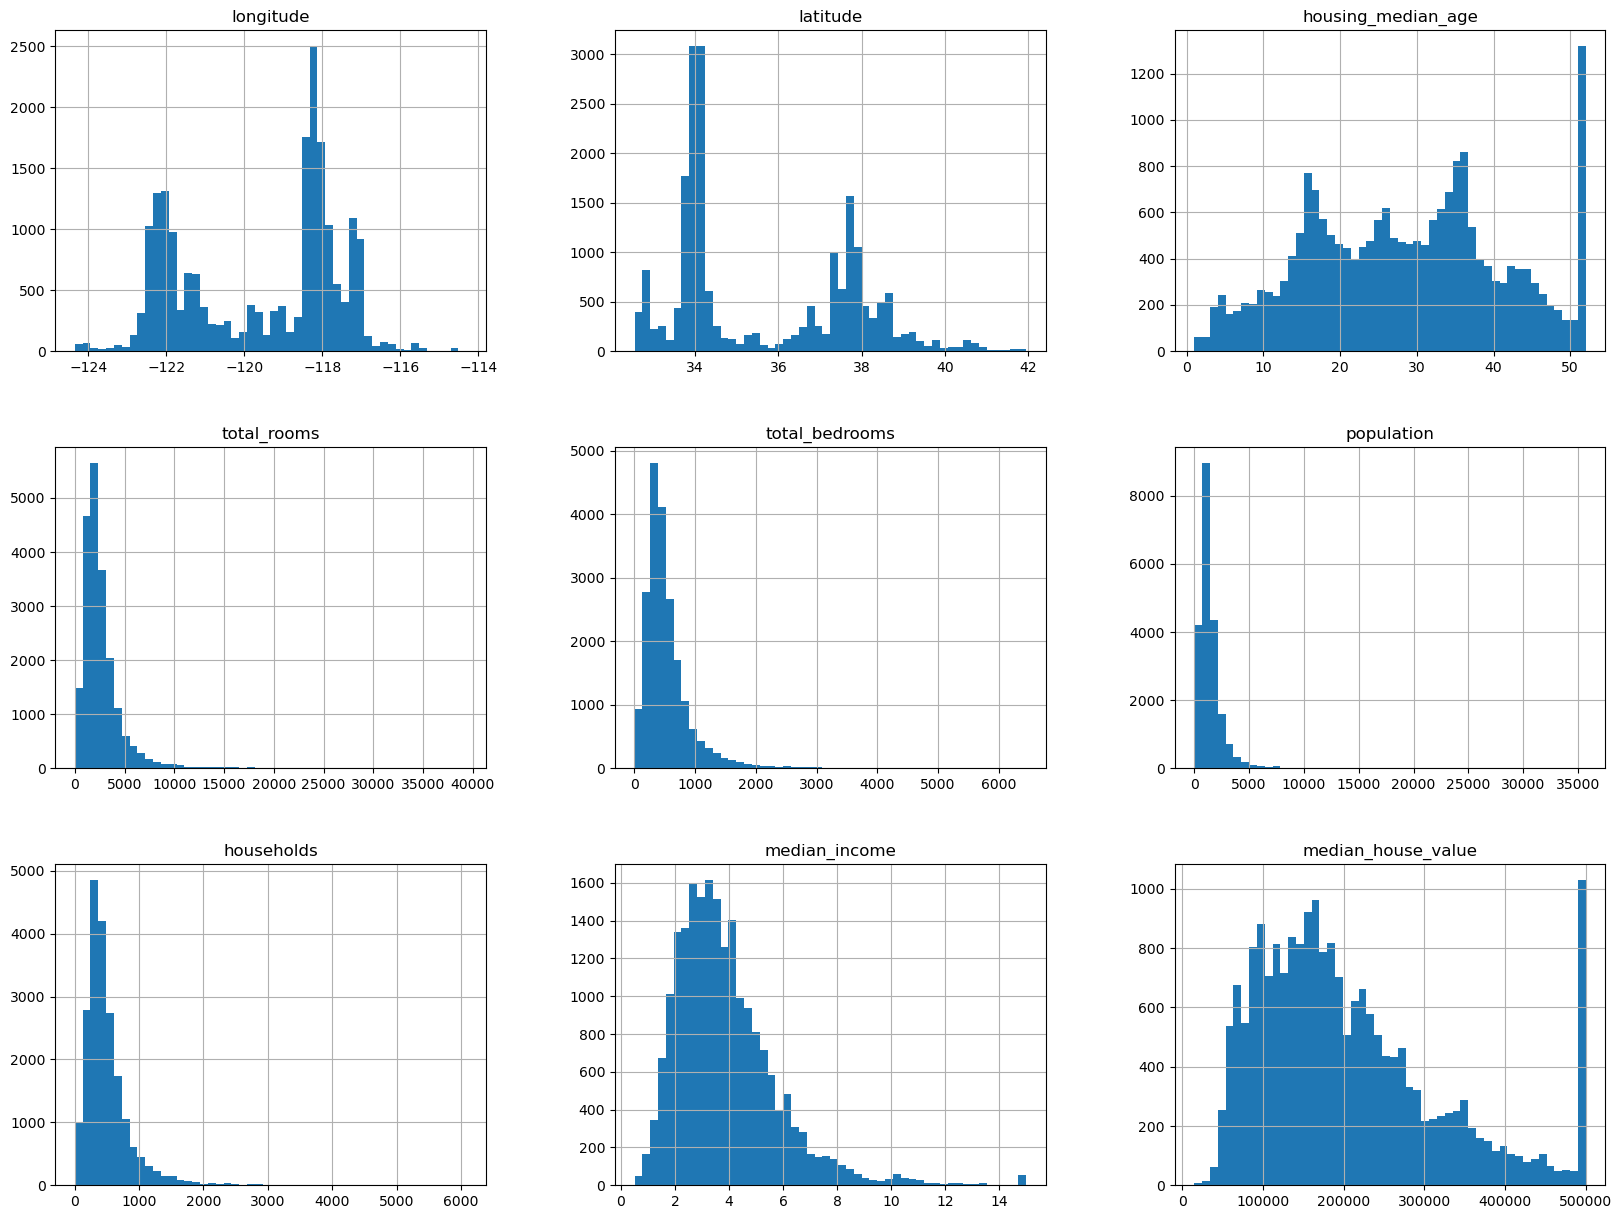

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15)) # only the float features will get a histogram
plt.show()

We can see that besides from `total_room`, `total_bedrooms`, `population`, `households` these naturally/geographically skewed features, we have `median_income` feature very skewed, which means that in out sample, we have a clear skewness towards low-income families. We then check whether there is a skewness in our categorical feature `ocean_proximity`. 

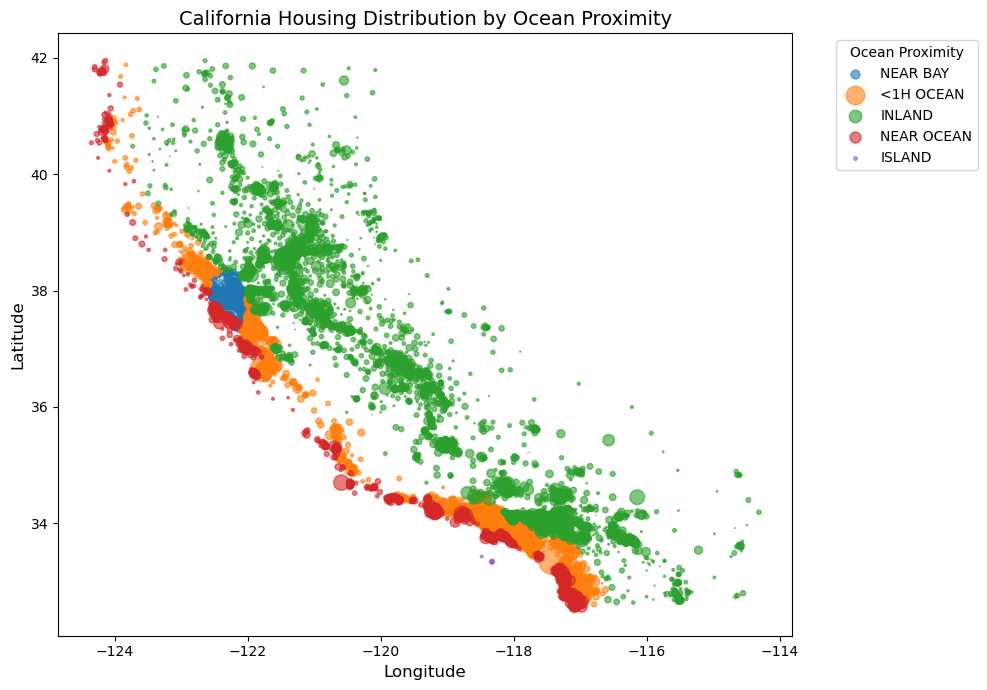

In [4]:
plt.figure(figsize=(10, 7))

for category in housing['ocean_proximity'].unique():
    mask = housing['ocean_proximity'] == category
    subset = housing[mask]
    plt.scatter(subset['longitude'], 
               subset['latitude'],
               s=subset['population']/100,
               alpha=0.6,
               label=category)

plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('California Housing Distribution by Ocean Proximity', fontsize=14)
plt.legend(title='Ocean Proximity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Sample size for each class:
ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64


/var/folders/8b/l9s5df5d50xc1fhgw2n5m9_m0000gn/T/ipykernel_79798/3268158997.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


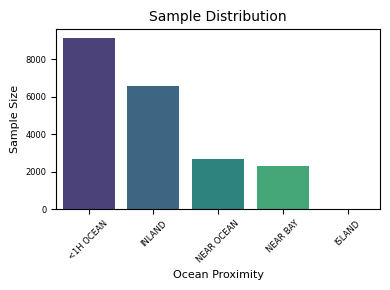

In [5]:
class_counts = housing['ocean_proximity'].value_counts()
print("Sample size for each class:")
print(class_counts)

import seaborn as sns

plt.figure(figsize=(4, 3))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xlabel("Ocean Proximity", fontsize=8)       
plt.ylabel("Sample Size", fontsize=8)           
plt.title("Sample Distribution", fontsize=10)    
plt.xticks(rotation=45, fontsize=6)            
plt.yticks(fontsize=6)                          
plt.tight_layout()
plt.show()

We see that for `ocean_proximity`, there is a skewness in our sample towards `<1H Ocean` and `Inland` on the mainland, therefore we shall do a stratification on it when splitting the train set and the test set. 

## 2. Split the Data into Training and Testing Sets


Since our categorical targe `ocean_proximity` is imbalanced, we stratify the split so that the training and test sets reflect the same class distribution as the whole dataset to reduce bias. 

In [6]:
# Separate features and target variable.
X = housing.drop('ocean_proximity', axis=1)
y = housing['ocean_proximity']

# Use stratification when splitting to maintain class proportions.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (16512, 9)
Test set shape: (4128, 9)


## 3. Build a Data Processing Pipeline

Because k‑nn uses distances, it is very important that all numerical features be on a similar scale. We build a pipeline that:

- **Imputes** missing values using the median.
- **Scales** the data with standardization.

We also define a custom transformer called `ColumnSelector` to allow easy selection (or removal) of columns, which will be useful for our feature importance analysis later.


In [7]:
# Define a custom transformer for selecting columns (optional but useful for feature selection)
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Custom transformer that selects a subset of columns from a DataFrame.
    """
    def __init__(self, columns=None):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.columns is not None:
            return X[self.columns]
        return X

# Build the preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Using median to fill in missing values
    ('scaler', StandardScaler())                    # Standardize features into mean 0 and variance 1
])

## 4. Build the Full Model Pipeline

We combine our preprocessing pipeline with the k‑nn classifier. Here, we specify the use of the Minkowski distance metric (we use $w=1$):

$$
d(x,y) = \sum(w \cdot |x - y|^p)^{\frac{1}{p}}
$$

We initially set the Minkowski parameter $ p=2 $ (i.e. Euclidean distance) but note that we will treat $p$ as a hyperparameter.

In [8]:
# Create the full model pipeline
model_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('knn', KNeighborsClassifier(metric='minkowski', p=2))  # Default: Euclidean distance
])

# Fit the pipeline on the training data
model_pipeline.fit(X_train, y_train)

# Evaluate on the test set
y_pred = model_pipeline.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred)
print("Baseline accuracy (with p=2):", baseline_accuracy)

Baseline accuracy (with p=2): 0.812015503875969


## 5. Compare Different Minkowski Distance Parameters

We now evaluate the performance of k‑nn using different $p$ values:

- \( $p$ = 1 \) (Manhattan distance)
- \( $p$ = 2 \) (Euclidean distance)
- \( $p$ = 10 \) (A high-order norm that may overly emphasize large differences)
- \( $p$ = -10 \) (A negative value, which does not produce a proper distance metric)

We expect \( $p$ = 2 \) and sometimes \( $p$ = 1 \) to perform well, while \( $p$ = 10 \) and \( $p$ = -10 \) may yield poor results.


In [9]:
def evaluate_knn_with_p(p_value, X_train, y_train, X_test, y_test):
    """
    Build a k-NN model with a given Minkowski p value,
    train it, and return the accuracy on the test set.
    """
    try:
        pipeline = Pipeline([
            ('preprocessing', preprocessing_pipeline),
            ('knn', KNeighborsClassifier(metric='minkowski', p=p_value))
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"Accuracy with p={p_value}: {acc:.4f}")
        return acc
    except Exception as e:
        print(f"Error with p={p_value}: {e}")
        return None

# Evaluate for selected p values.
p_values = [1, 2, 10, -10]
results = {}
for p in p_values:
    results[p] = evaluate_knn_with_p(p, X_train, y_train, X_test, y_test)


Accuracy with p=1: 0.8331
Accuracy with p=2: 0.8120
Accuracy with p=10: 0.7929
Error with p=-10: The 'p' parameter of KNeighborsClassifier must be a float in the range (0.0, inf] or None. Got -10 instead.


**Remarks:**  
- \( $p$=1 \) produces the best classification accuracy by the score function `accuracy_score`.
- \( $p$=2 \) typically yields competitive results.  
- \( $p$=10 \) may result in a model that is too sensitive to large differences in a few dimensions, but in our case, it is still fine.
- \( $p$=-10 \) is not a proper value (as Minkowski distance requires \( $p \geq 1$ \)); hence, we expect errors or very poor performance.

## 6. Hyperparameter Tuning with GridSearchCV

We now use `GridSearchCV` to search for the optimal Minkowski $p$ value (over a reasonable range). This will train several models using cross-validation and select the best parameter. As a result, we see that $p=1$ is the optimal parameter value in the range of $[1,10]$ with step size $0.125$, in other words, Manhattan Distance is our best choice by CV. 


In [10]:
# Define the parameter grid for p values (we consider values 1 through 10 with step 0.125)
param_grid = {'knn__p': np.arange(1, 10.125, 0.125)}

# Create GridSearchCV
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameter from GridSearchCV:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

/Users/kehanluo/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best parameter from GridSearchCV: {'knn__p': 1.0}
Best cross-validation accuracy: 0.8317591353271157


## 7. Feature Importance Analysis by Removal

Since k‑nn does not provide feature coefficients, we can gauge feature importance by removing one feature at a time from the dataset and observing the drop in accuracy.

**Steps:**
1. Compute the baseline accuracy using the best \( $p=1$ \) found previously by CV.
2. For each feature, remove it from both training and test sets.
3. Train a new model (using the best \( $p=1$ \)) and record the accuracy.
4. The feature whose removal results in the largest drop in accuracy is likely the most important.

**Note:** We use the same preprocessing steps to ensure consistency.

In [11]:
# Extract the best p value from GridSearchCV.
best_p = grid_search.best_params_['knn__p']
print("Using best p =", best_p)

# Build the pipeline with the best p value.
best_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('knn', KNeighborsClassifier(metric='minkowski', p=best_p))
])
best_pipeline.fit(X_train, y_train)
full_accuracy = accuracy_score(y_test, best_pipeline.predict(X_test))
print("Full model accuracy with all features:", full_accuracy)

Using best p = 1.0
Full model accuracy with all features: 0.8330910852713178


In [12]:
# Evaluate the effect of removing each feature.
feature_importance = {}

for feature in X_train.columns:
    # Remove one feature from the training and test sets.
    X_train_mod = X_train.drop(columns=[feature])
    X_test_mod = X_test.drop(columns=[feature])
    
    # Build and fit a new pipeline on the modified data.
    pipeline_mod = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(metric='minkowski', p=best_p))
    ])
    pipeline_mod.fit(X_train_mod, y_train)
    acc_mod = accuracy_score(y_test, pipeline_mod.predict(X_test_mod))
    feature_importance[feature] = acc_mod
    # print(f"Accuracy without '{feature}': {acc_mod:.4f}")

print("\nBaseline accuracy with all features:", full_accuracy)
print("Drop in accuracy when each feature is removed:")

# Sort accuracy from lowest to highest
for feature, acc in sorted(feature_importance.items(), key=lambda x: x[1]):
    drop = full_accuracy - acc
    print(f"  {feature}: Accuracy = {acc:.4f}, drop = {drop:.4f}")



Baseline accuracy with all features: 0.8330910852713178
Drop in accuracy when each feature is removed:
  longitude: Accuracy = 0.7689, drop = 0.0642
  latitude: Accuracy = 0.7723, drop = 0.0608
  median_house_value: Accuracy = 0.8232, drop = 0.0099
  total_rooms: Accuracy = 0.8333, drop = -0.0002
  population: Accuracy = 0.8372, drop = -0.0041
  total_bedrooms: Accuracy = 0.8384, drop = -0.0053
  households: Accuracy = 0.8396, drop = -0.0065
  housing_median_age: Accuracy = 0.8435, drop = -0.0104
  median_income: Accuracy = 0.8491, drop = -0.0160


We can see a very interesting result here. It is pretty reasonable that `longitude` and `latitue` play vital roles in `ocean_proximity`, so they are the most positively important ones. Geophracially, California is roughly 45-degrees rotated, so `longitude` and `latitue` nearly have equal importance toward `ocean_proximity`. Also, `median_house_value` shows a positive importance toward `ocean_proximity` which is mainly because housing price could be directly related to the ocean proximity (everyone likes ocean!). On the other hand, `median_income` shows the most negative importance on `ocean_proximity`, which I think is because `median_income` has a pretty strong correlation with `median_house_value`, but regarding `ocean_proximity`, it plays a somehow opposite affect compared to `median_house_value`, so it turns into a disturbing adversarial feature. Exluding `median_house_value` will cause the model to learn more effectively. Last but not least, `total_rooms`, `population`, `total_bedrooms`, `households` play least or nearly no importance on `ocean_proximity`. 

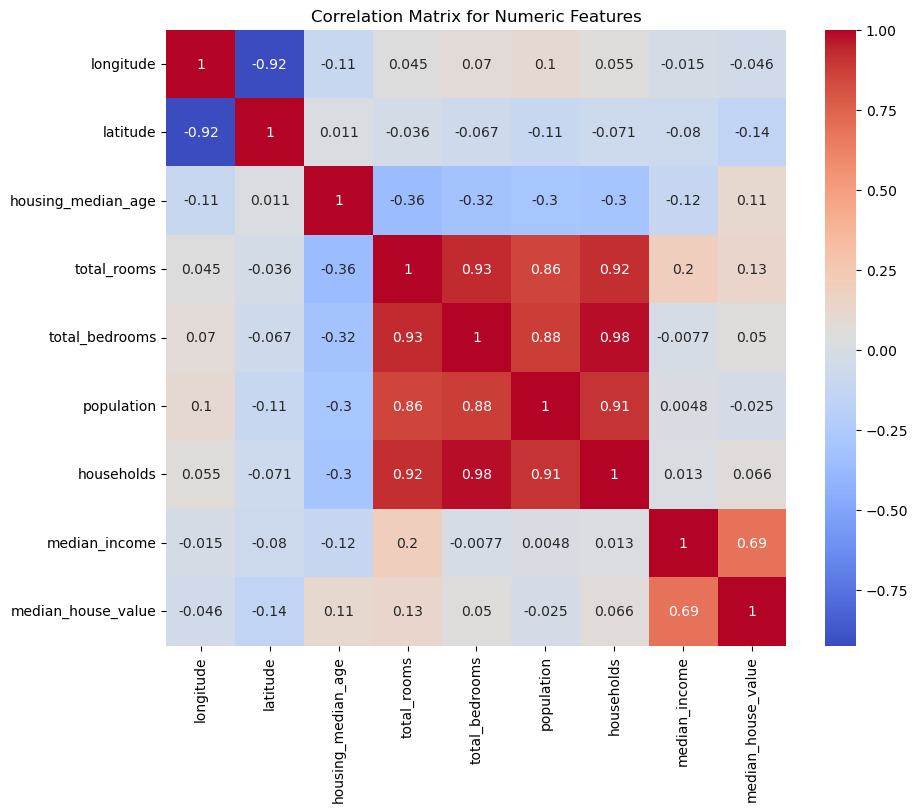

In [13]:
import seaborn as sns

corr_matrix = housing.drop(columns='ocean_proximity').corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix for Numeric Features")
plt.show()

## Conclusions

- **Data Splitting:** Stratification is essential because our target `ocean_proximity` is a categorical and imbalanced variable.
- **Preprocessing:** Imputation and scaling are critical for distance-based algorithms like k‑nn.
- **Model Pipeline:** We combined preprocessing with a k‑nn classifier that uses the Minkowski distance.
- **Distance Metric \( $p$ \):** While we usually use ( $p$=2 \) (Euclidean Distance), experimental result shows favor for \( $p$=1 \) (Manhattan Distance). Extreme positive values (such as \( $p$=10 \)) shows poorer result, and negative values (like \( $p$=-10 \)) are invalid. 
- **Hyperparameter Tuning:** GridSearchCV successfully identified the best \( $p$ \) value as $p=1$.
- **Feature Importance:** By removing features one at a time, we can assess their contributions. Features `longtitude` and `latitude` show nearly equivalent strongest importance toward `ocean_proximity`.

This notebook demonstrates a complete pipeline for tackling the k‑nn classification task on the California housing dataset. 
